In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models
from PIL import Image
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score


In [8]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        # transforms.RandomRotation(degrees=15),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        # transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [9]:
 #Load the Data

# Set train and valid directory paths

dataset = 'skindiseasesplit'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'test')

# Batch size
bs = 64

# Number of classes
num_classes = len(os.listdir(test_directory))  #10#2#257
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
classes = {v: k for k, v in data['train'].class_to_idx.items()}
print(classes)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
test_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

10
{0: 'Acne', 1: 'Dermatitis', 2: 'Eczema', 3: 'Impetigo', 4: 'Melanoma', 5: 'Psoriasis', 6: 'Ringworm', 7: 'Rosacea', 8: 'Urticaria Hives', 9: 'Vitiligo'}


In [10]:
model = models.densenet169(weights= models.DenseNet169_Weights.IMAGENET1K_V1)
model = models.densenet169(weights="IMAGENET1K_V1")
model = models.densenet169(pretrained=True)
model = models.densenet169(True)

# Freeze all layers except the final classifier
for param in model.parameters():
    param.requires_grad = False
    
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, num_classes)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [12]:
num_epochs = 10

train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
train_precisions, test_precisions, train_recalls, test_recalls, train_f1_scores, test_f1_scores = [], [], [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    train_preds = []
    train_labels = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        # Collect predictions and true labels for later use
        train_preds.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Calculate precision, recall, and F1-score for training data
    train_precision = precision_score(train_labels, train_preds, average='macro')
    train_recall = recall_score(train_labels, train_preds, average='macro')
    train_f1 = f1_score(train_labels, train_preds, average='macro')

    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    test_preds = []
    test_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
            # Collect predictions and true labels for later use
            test_preds.extend(predicted.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

        test_accuracy = correct_test / total_test
        test_loss = test_loss / len(test_loader)

        # Calculate precision, recall, and F1-score for testing data
        test_precision = precision_score(test_labels, test_preds, average='macro')
        test_recall = recall_score(test_labels, test_preds, average='macro')
        test_f1 = f1_score(test_labels, test_preds, average='macro')

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_precisions.append(train_precision)
    test_precisions.append(test_precision)
    train_recalls.append(train_recall)
    test_recalls.append(test_recall)
    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")
    print(" -------------------------------------------- ")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")
    

Epoch 1/10
Train Loss: 1.3558, Train Accuracy: 0.5343, Train Precision: 0.5443, Train Recall: 0.5220, Train F1: 0.5294
 -------------------------------------------- 
Test Loss: 1.0718, Test Accuracy: 0.6680, Test Precision: 0.6953, Test Recall: 0.6908, Test F1: 0.6506
Epoch 2/10
Train Loss: 0.8638, Train Accuracy: 0.7092, Train Precision: 0.7223, Train Recall: 0.7143, Train F1: 0.7169
 -------------------------------------------- 
Test Loss: 0.8860, Test Accuracy: 0.6640, Test Precision: 0.7688, Test Recall: 0.6591, Test F1: 0.6774


KeyboardInterrupt: 

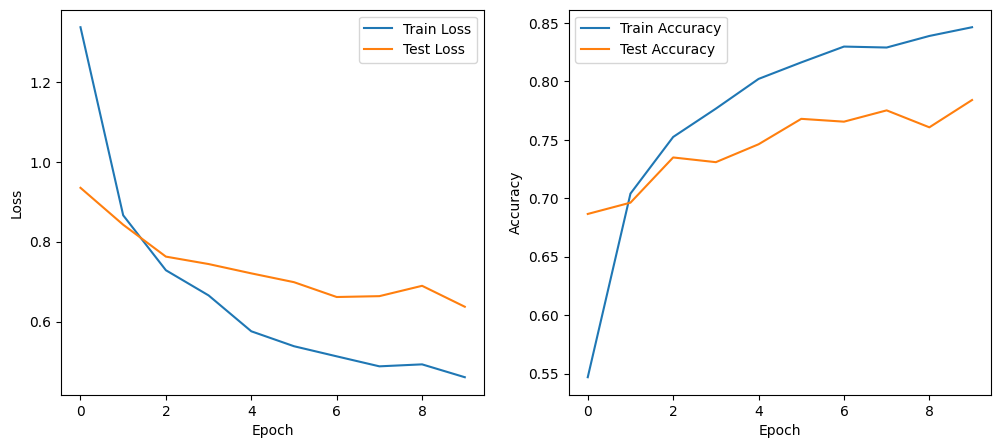

In [ ]:
# Plot training and testing loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot training and testing accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()



In [ ]:
torch.save(model.state_dict(), 'densenet169.pth')

In [ ]:
loaded_model = models.densenet169(pretrained=True)
in_features = loaded_model.classifier.in_features
loaded_model.classifier = nn.Linear(in_features, num_classes)  # Replace 'num_classes' with the number of your classes

# Load the state dictionary into the new model
checkpoint = torch.load('densenet169.pth')
loaded_model.load_state_dict(checkpoint)

# Move the model to the desired device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_model = loaded_model.to(device)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
accuracy_threshold = 0.7  # Adjust this threshold as needed

def test_single_image(image_path, model, threshold):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output.data, 1)
        probabilities = torch.softmax(output, dim=1)
    
    predicted_class = predicted.item()
    max_probability = torch.max(probabilities).item()
    
    # Check if the maximum probability is below the threshold
    if max_probability < threshold:
        return "Unknown disease", max_probability
    else:
        predicted_label = classes[predicted_class]
        return predicted_label, max_probability

new_image_path = 'what-is-eczema-02-hand-eczema-722x406 (1).jpg'
predicted_class, accuracy = test_single_image(new_image_path, loaded_model, accuracy_threshold)
print(f'Predicted Class: {predicted_class}, Accuracy: {accuracy:.4f}')

Predicted Class: Eczema, Accuracy: 0.9446
